In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm 
import arviz as az

# Dataset

In [55]:
np.random.seed(42)

x = np.linspace(0, 1, 200)
y = 1.0 + 2.0 * x + np.random.normal(0, 0.1, size=len(x))


### True Model

$$ y = \beta_0 + \beta_1 x + \varepsilon $$ 

### Model 1:

$$ y = \beta_0 + \beta_1 x + \varepsilon $$ 

### Model 2: 

$$y = \beta_0 + \beta_1 x + \beta_2 x^2 + \varepsilon$$

In [59]:
# Model 1: Linear
with pm.Model() as linear_model:
    sigma = pm.HalfNormal("sigma", 1)
    beta0 = pm.Normal("beta0", 0, 10)
    beta1 = pm.Normal("beta1", 0, 10)
    
    mu = beta0 + beta1 * x
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    trace_linear = pm.sample(nuts_sampler="numpyro", draws=1000, tune=1000,
                              return_inferencedata=True, idata_kwargs={"log_likelihood": True})
    pm.sample_posterior_predictive(trace_linear, extend_inferencedata=True)


# Model 2: Quadratic
with pm.Model() as quadratic_model:
    sigma = pm.HalfNormal("sigma", 1)
    beta0 = pm.Normal("beta0", 0, 10)
    beta1 = pm.Normal("beta1", 0, 10)
    beta2 = pm.Normal("beta2", 0, 10)

    mu = beta0 + beta1 * x + beta2 * x**2
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    trace_quadratic = pm.sample(nuts_sampler="numpyro", draws=1000, tune=1000, 
                                return_inferencedata=True, idata_kwargs={"log_likelihood": True})

    pm.sample_posterior_predictive(trace_quadratic, extend_inferencedata=True)


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1834.14it/s]
Sampling: [y_obs]


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1500.54it/s]
Sampling: [y_obs]


In [60]:
model_dict = dict(zip(["model_1", "model_2"], [trace_linear, trace_quadratic]))
comp = az.compare(model_dict)
comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_1,0,188.986858,2.940565,0.000000,1.0,9.850506,0.000000,False,log
model_2,1,188.022662,3.921136,0.964196,0.0,9.955134,0.352465,False,log


In [61]:
ppc_w = az.weight_predictions(
    [model_dict[name] for name in comp.index],
    weights=comp.weight,
)

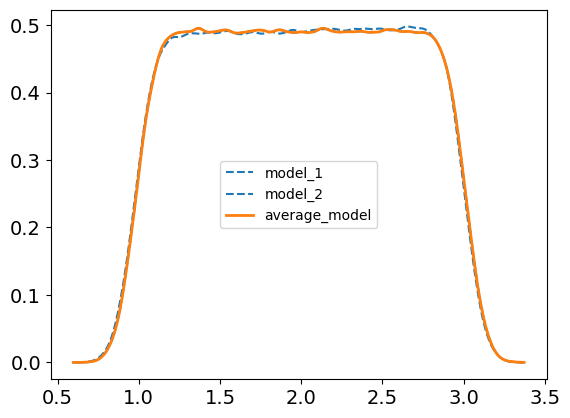

In [84]:
az.plot_kde(
    trace_linear.posterior_predictive["y_obs"].values,
    plot_kwargs={"color": "C0", "linestyle": "--"},
    label="model_1",
)
az.plot_kde(
    trace_quadratic.posterior_predictive["y_obs"].values,
    plot_kwargs={"color": "C0", "linestyle": "--"},
    label="model_2",
)
az.plot_kde(
    ppc_w.posterior_predictive["y_obs"].values,
    plot_kwargs={"color": "C1", "linewidth": 2},
    label="average_model",
);